## ProjF5 - Final Model

Use this document as a template to provide the evaluation of your final model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

## Neural Networks Powered Speed Control

Presentation Deck: [Google Slides](https://docs.google.com/presentation/d/1okGnbLBmDcSId6vHH3SXqi8irRW5jm92MP0RYyESFm4/edit?usp=sharing)

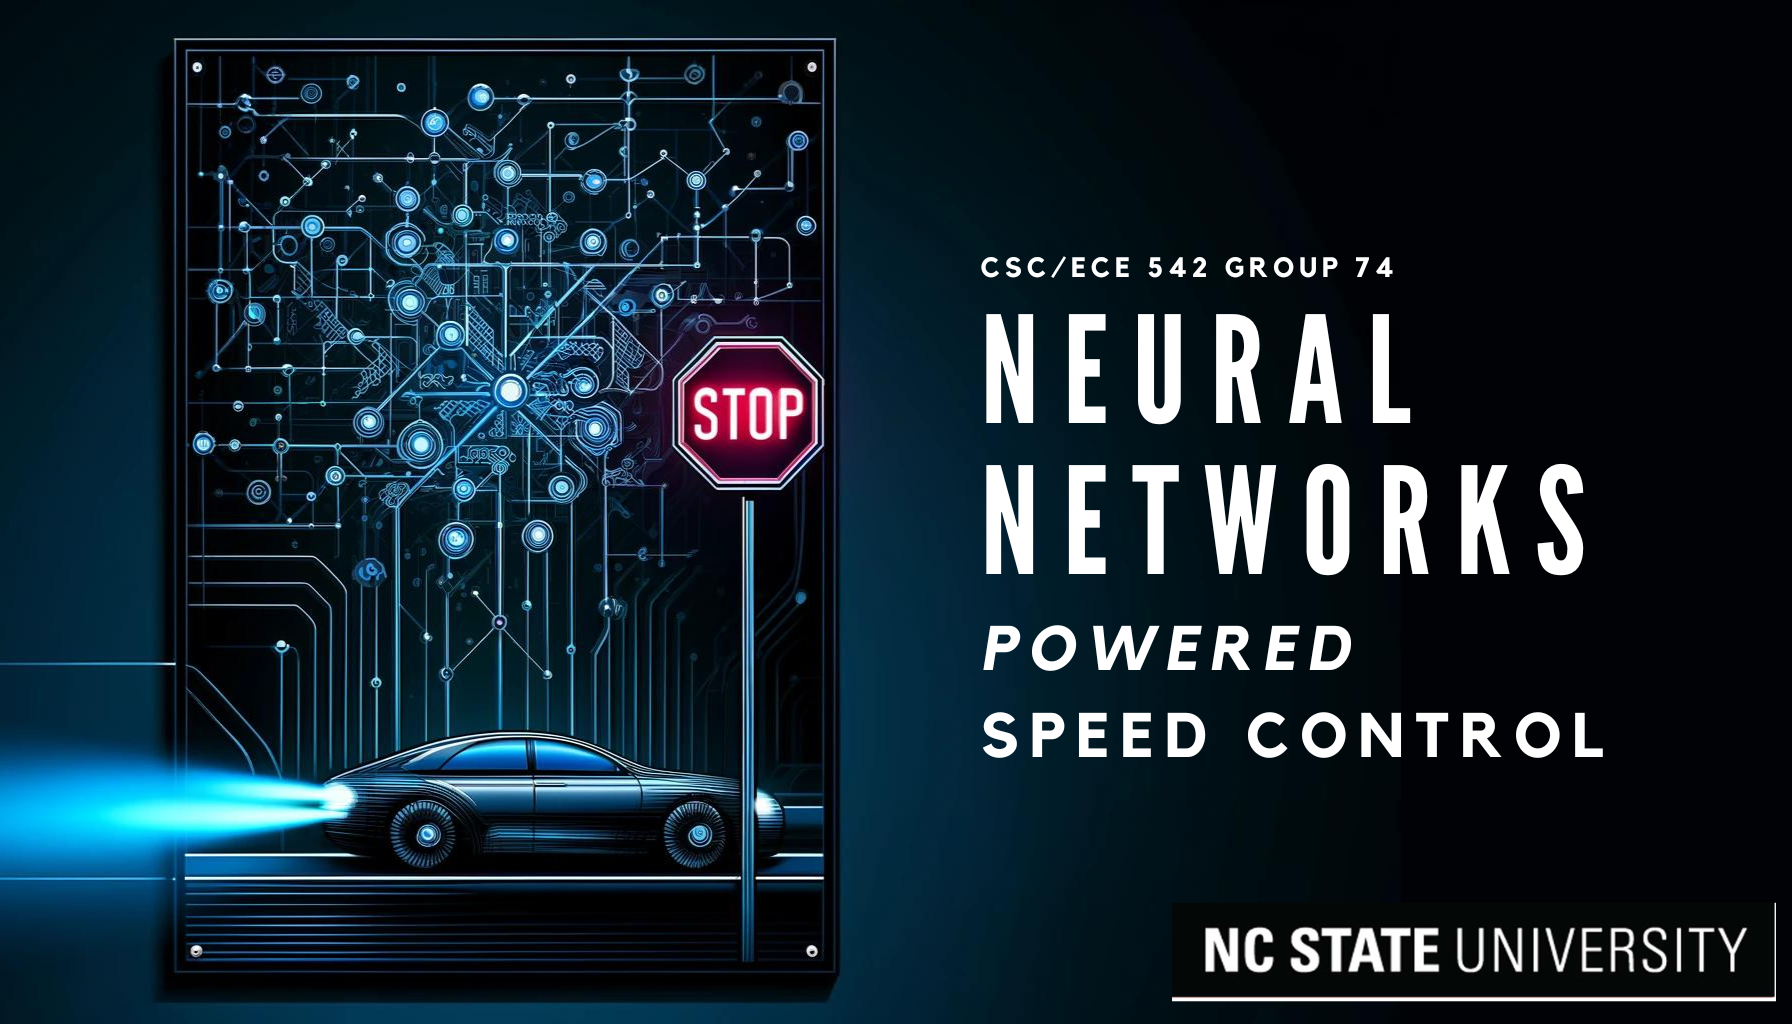

In [64]:
from IPython.display import Image, display

image_path = 'Group74_Poster.png'
display(Image(filename=image_path))


### Addtional Python Modules requried

In [65]:
import os
import subprocess

### Intalling additional libraries

In [66]:
!pip3 install opencv-python
!pip3 install opencv-contrib-python
!pip3 install matplotlib
!pip3 install pillow
!pip3 install tensorflow
!pip3 install scipy
!pip3 install labelimg #data annotation tool

### Importing additional libraries

In [81]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image

### Installing Darknet

The code will only run if the darknet directory is not already present in your code folder. 

In [82]:
if not os.path.exists("darknet"):
    subprocess.run(["git", "clone", "https://github.com/pjreddie/darknet"], check=True)
    os.chdir("darknet")
    subprocess.run(["make"], check=True)
else:
    print("The directory already exists.")


The directory already exists.


### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

### Loading the data

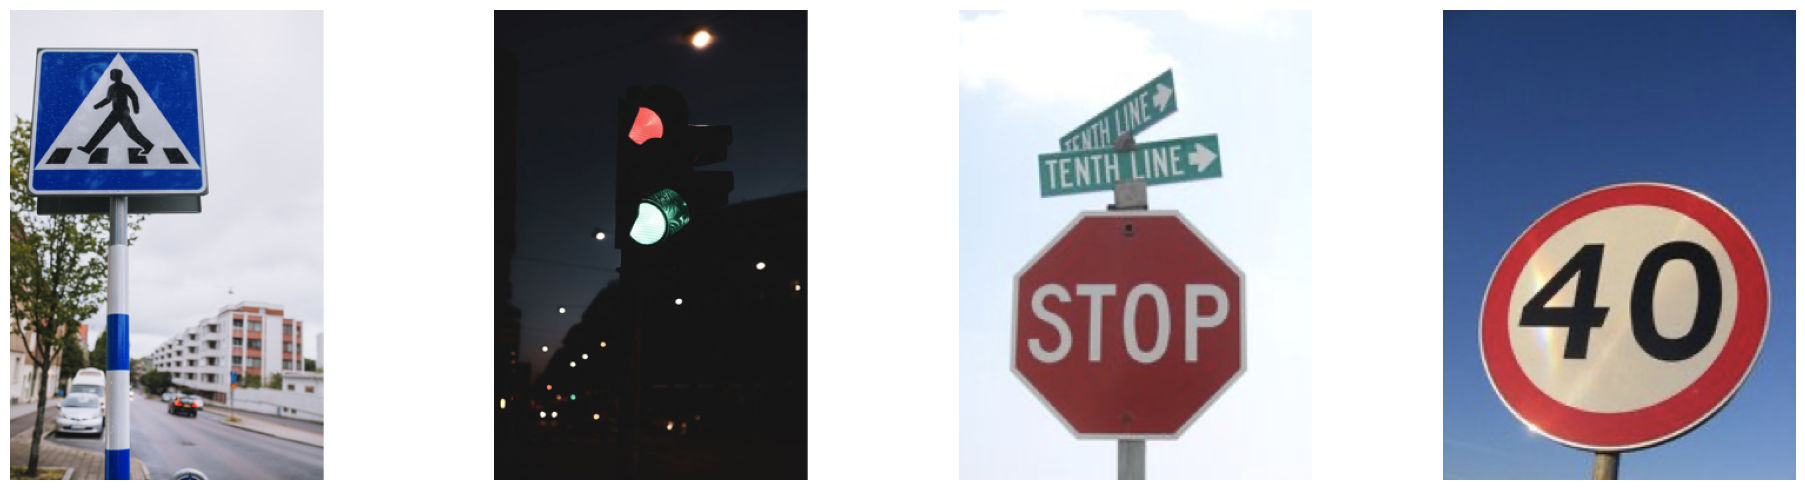

In [83]:
# from IPython.display import Image, display

directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/dataset/sample_data'  

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith('.jpg') or file.endswith('.png')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figure size as needed

for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(directory_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout()
plt.show()


### Data Augmentation

Compared to our baseline model we found that training the model on augmented data could yield better results. This gives the model a chance to train on variations of data is has seen before thus adding to the prediction of the model.

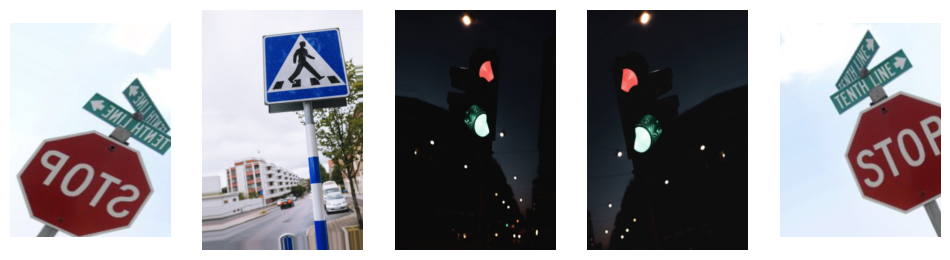

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

source_dir = 'dataset/sample_data'
augmented_dir = 'dataset/augmented_data'
os.makedirs(augmented_dir, exist_ok=True)

data_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def is_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def augment_and_save_images(img_filename, num_augmented=5):
    img_path = os.path.join(source_dir, img_filename)
    try:
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        save_prefix = "augmented_" + os.path.splitext(img_filename)[0]
        i = 0
        for batch in data_gen.flow(img_array, batch_size=1,
                                   save_to_dir=augmented_dir, 
                                   save_prefix=save_prefix, 
                                   save_format='png'):
            i += 1
            if i >= num_augmented:
                break
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

def display_images(directory):
    plt.figure(figsize=(12, 12))
    for i, img_filename in enumerate(os.listdir(directory)[:5]):
        img_path = os.path.join(directory, img_filename)
        img = plt.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

for filename in os.listdir(source_dir):
    if is_image_file(filename):
        augment_and_save_images(filename)

display_images(augmented_dir)


### Preparing for Model Training

[ ] Data Annotation <br>
[ ] YOLO Project Structure Setup <br>
[ ] Neural Network Configuration Setup <br>

### Post Model Training Completion

[ ] Python Code to test the network over unseen data 1. Static Data (Images) 2. Real Time Data (Videos and/or Live Camera Feed) <br>
[ ] How could we improve the testing accuracy? <br>

### Step 1: Data Annotation (Done using a tool in Python: LabelImg)

Preparing the data so that it is the correct format to be read and processed by the neural network

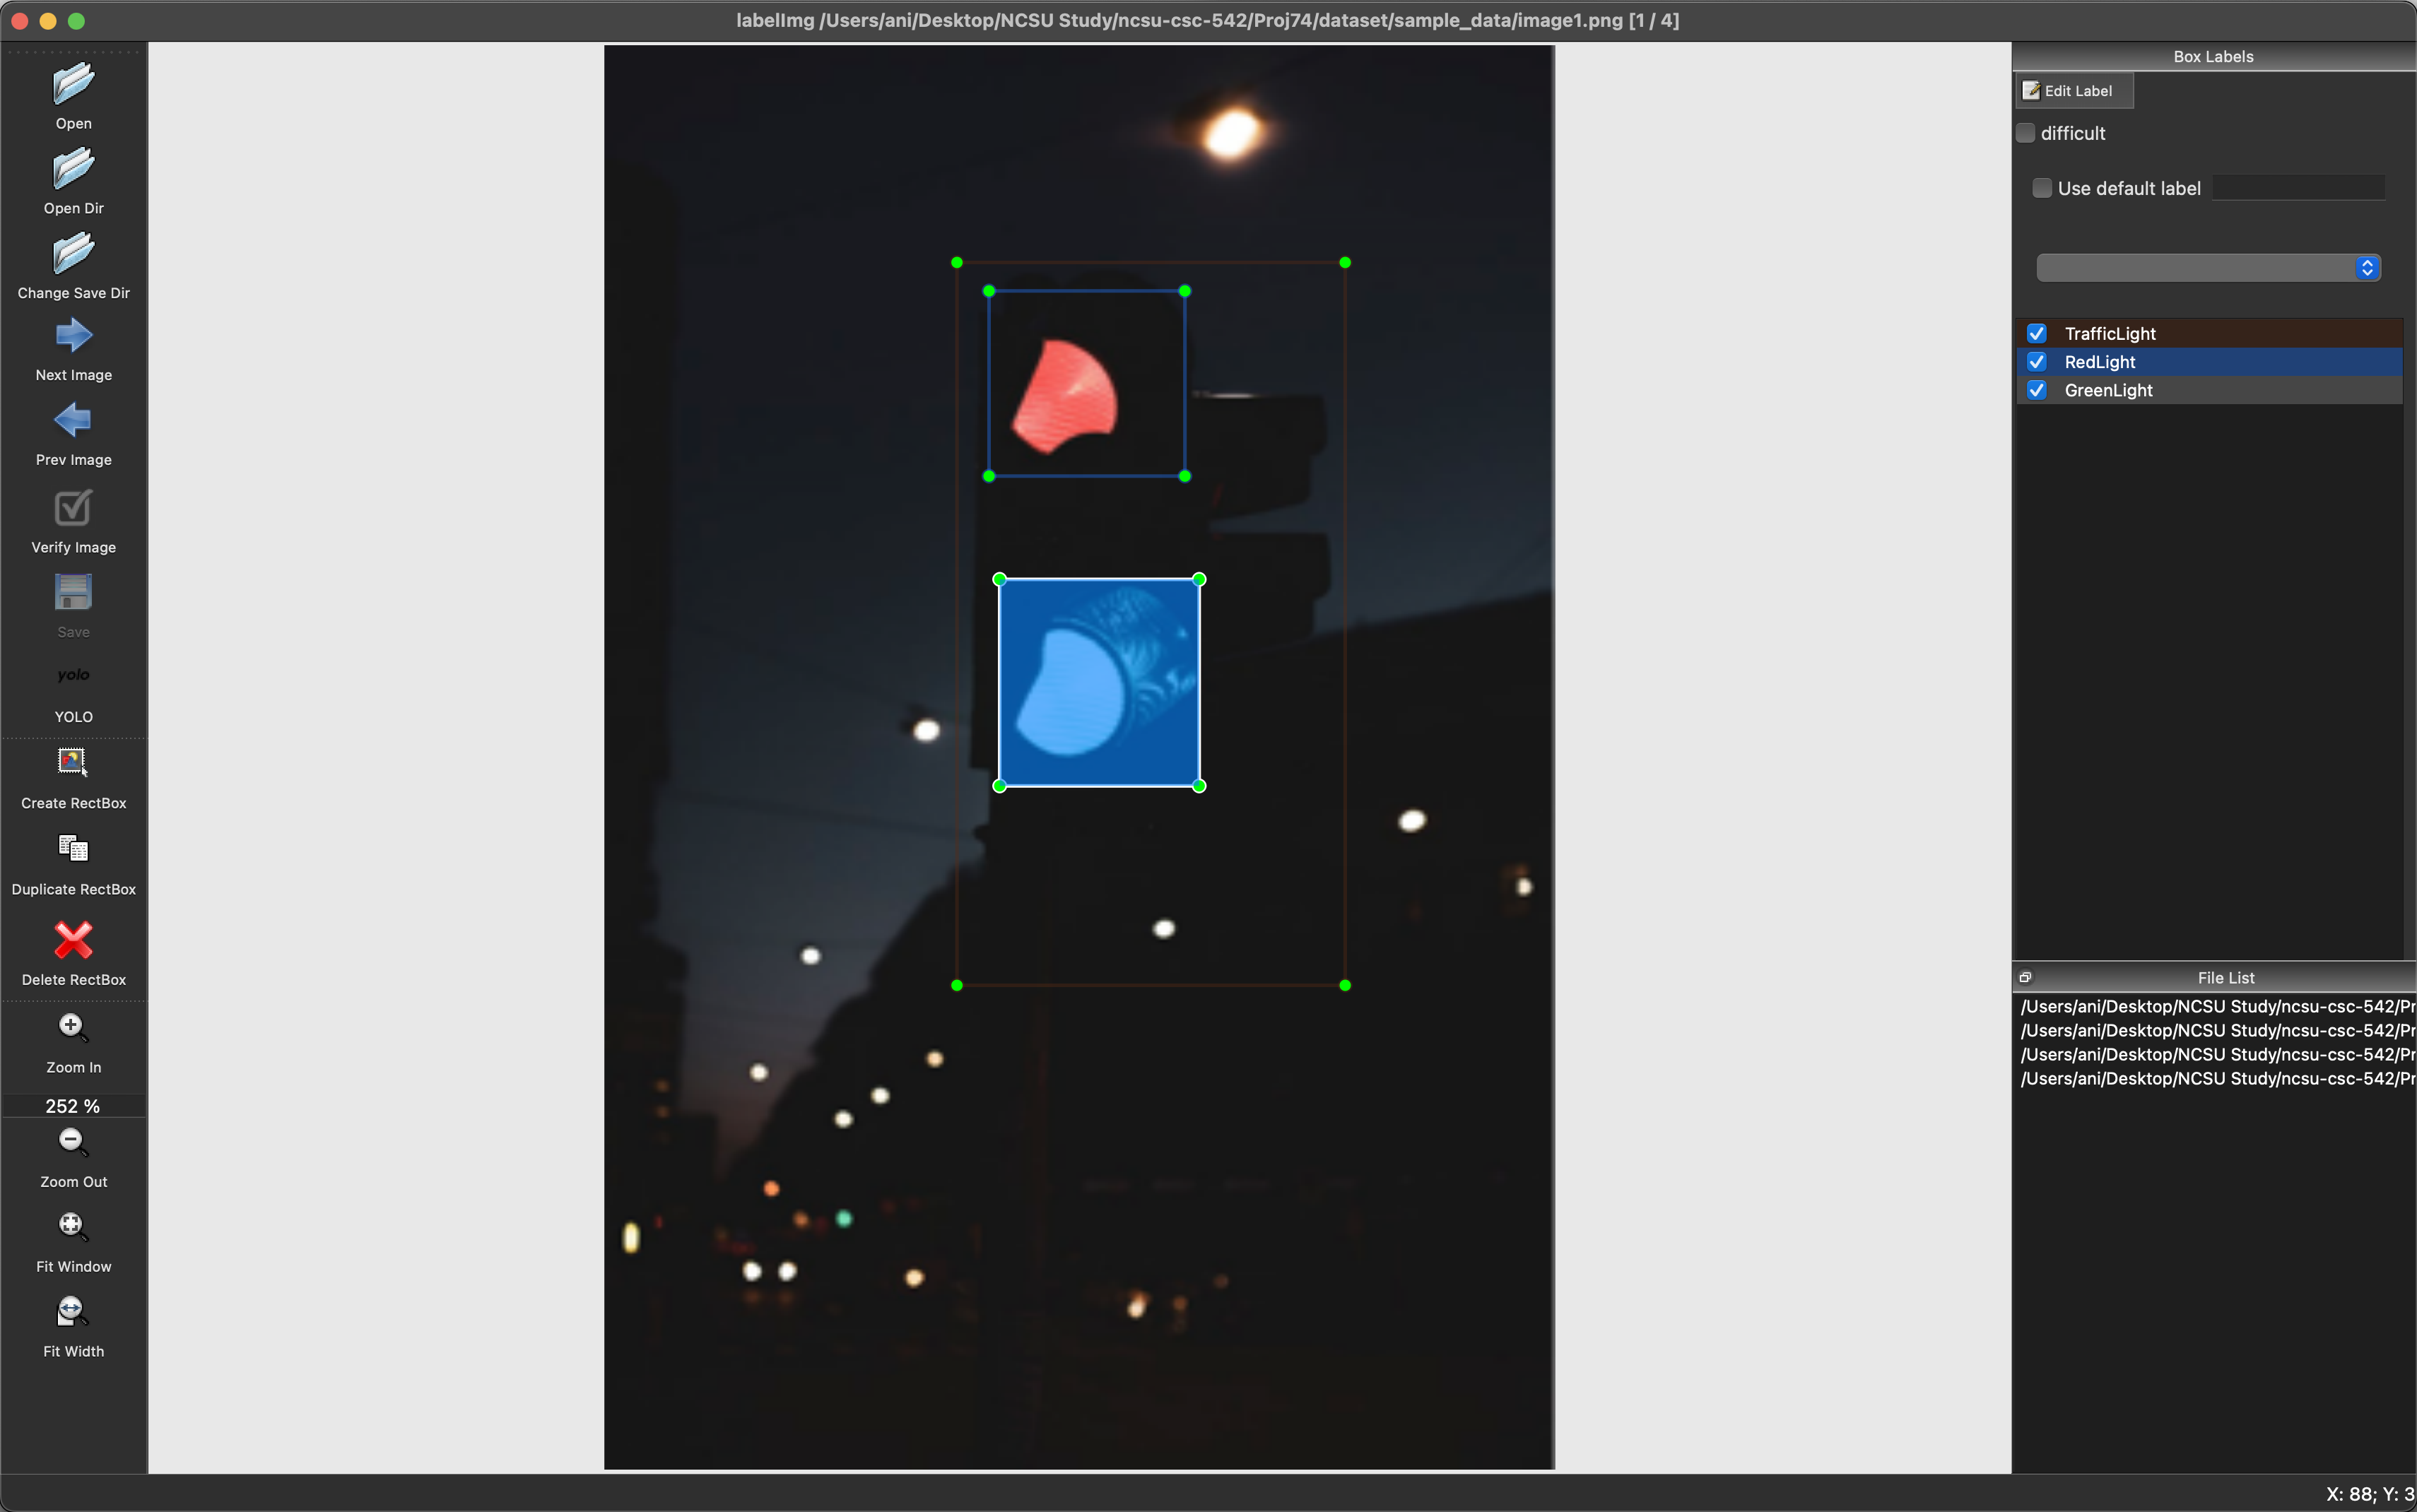

In [85]:
from IPython.display import Image, display

image_path = 'Screenshot 2024-04-25 at 21.43.45.png'
display(Image(filename=image_path))


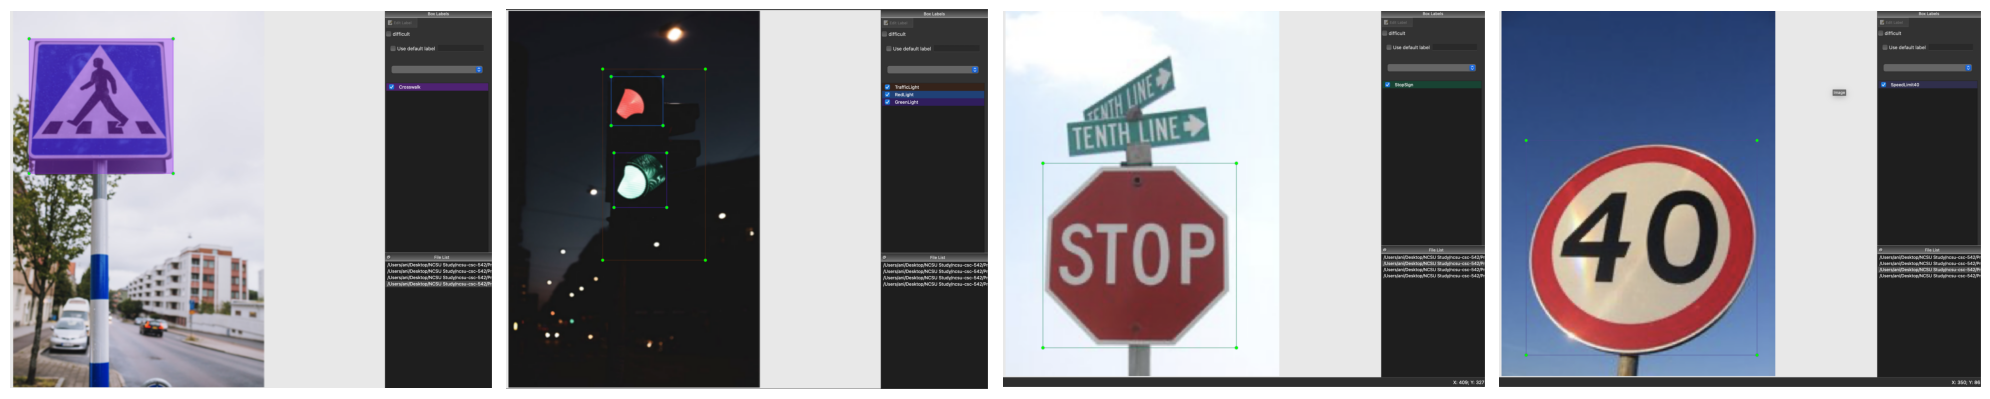

In [86]:
from PIL import Image

directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/dataset/annotated_images' 

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith('.jpg') or file.endswith('.png')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  

for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(directory_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  

plt.tight_layout()
plt.show()


### What does the green bounding box represent?

The green bounding box represents the region of interest that contains the class of the image that is parsed into the neural network. Every class is labelled with a particular number/index starting from 0. If your dataset consists of 10 classes, indexes will be generated from 0 upto 9.

Each time we annotate a file with labelImg, a text file containing details about the ROI of the class is generated in a format acceptable to a model trained with YOLO.

### Format of these files

``` object-class, x-center, y-center, width, height ```

In [87]:
directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/dataset/sample_data_annotated'  

text_files = [f for f in os.listdir(directory_path) if f.endswith('.txt') and f != 'classes.txt']

for text_file in text_files:
    file_path = os.path.join(directory_path, text_file)
    
    with open(file_path, 'r') as file:
        content = file.read()
    
    print(f"{text_file}\n{content}")

image4.txt
5 0.346442 0.251250 0.573034 0.357500

image1.txt
0 0.574906 0.406250 0.408240 0.507500
1 0.507491 0.237500 0.205993 0.130000
2 0.520599 0.447500 0.209738 0.145000

image3.txt
4 0.511667 0.648750 0.843333 0.587500

image2.txt
3 0.490000 0.670000 0.706667 0.505000



### Preparing for Model Training

[x] Data Annotation <br>
[ ] YOLO Project Structure Setup <br>
[ ] Neural Network Configuration Setup <br>

### Post Model Training Completion

[ ] Python Code to test the network over unseen data 1. Static Data (Images) 2. Real Time Data (Videos and/or Live Camera Feed) <br>
[ ] How could we improve the testing accuracy? <br>

### Step 2: YOLO Project Structure Setup

[Source] <i> [YOLO- You Only Look Once](https://pjreddie.com/darknet/yolo/) </i> <br>


YOLO applies a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities. <br>

For the purposes of this project we have used Tiny YOLOv3, a small version meant for constrained environements especially where compuatational power is not readily available at hand. 

Prequisites to train the model:- <br>

[ ] object.names - File containing all classes to be trained inside the model <br>
[ ] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[ ] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[ ] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[ ] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[ ] Configuration File- Hyperparameters and model training parameters for the neural network <br>

### What classes are present in our model?

In [91]:
file_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/dataset/sample_data_annotated/object.names'  

with open(file_path, 'r') as file:
    content = file.read()

print("Classes present in the Dataset:\n")
print(content)

Classes present in the Dataset:

TrafficLight
RedLight
GreenLight
StopSign
SpeedLimit10
SpeedLimit20
SpeedLimit30
SpeedLimit40
SpeedLimit50
SpeedLimit60
SpeedLimit70
SpeedLimit80
SpeedLimit90
SpeedLimit100
Crosswalk



Prequisites to train the model:- <br>

[x] object.names - File containing all classes to be trained inside the model <br>
[ ] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[ ] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[ ] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[ ] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[ ] Configuration File- Hyperparameters and model training parameters for the neural network <br>

### Training dataset - train.txt

In [125]:
file_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/train.txt'  

with open(file_path, 'r') as file:
    content = file.read()

print(content)

/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/0/0_1.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/0/0_2.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/0/0_3.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/0/0_4.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/0/0_5.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/0/0_6.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/10/10_1.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/10/10_2.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/10/10_3.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/10/10_4.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/10/10_5.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/dataset/20/2

Prequisites to train the model:- <br>

[x] object.names - File containing all classes to be trained inside the model <br>
[x] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[ ] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[ ] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[ ] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[ ] Configuration File- Hyperparameters and model training parameters for the neural network

### Testing Data - test.txt

In [124]:
file_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/test.txt'  

with open(file_path, 'r') as file:
    content = file.read()

print(content)

/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/0/0_7.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/10/10_6.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/20/20_6.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/30/30_2.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/40/40_2.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/50/50_3.png
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/60/60_5.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/70/70_2.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/70/70_3.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/80/80_4.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542dataset/80/80_6.jpeg
/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542datase

Prequisites to train the model:- <br>

[x] object.names - File containing all classes to be trained inside the model <br>
[x] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[x] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[ ] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[ ] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[ ] Configuration File- Hyperparameters and model training parameters for the neural network <br>

### Configuring paths for Model Training - trainer.data

In [123]:
file_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/trainer.data'  

with open(file_path, 'r') as file:
    content = file.read()

print(content)

classes=15
train=./csc542/train.txt
valid=./csc542/test.txt
names=./csc542/object.names
backup=./csc542/


Prequisites to train the model:- <br>

[x] object.names - File containing all classes to be trained inside the model <br>
[x] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[x] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[x] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[ ] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[ ] Configuration File- Hyperparameters and model training parameters for the neural network <br>

### Weights File created on running the model

In [103]:
ls -lh '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/yolot.backup' | awk '{print $9, $5}'


/Users/ani/Desktop/NCSU 33M


Prequisites to train the model:- <br>

[x] object.names - File containing all classes to be trained inside the model <br>
[x] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[x] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[x] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[x] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[ ] Configuration File- Hyperparameters and model training parameters for the neural network <br>

### Configuration Parameters for the Neural Network - yolot.cfg

In [122]:
file_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/yolot.cfg'  

with open(file_path, 'r') as file:
    content = file.read()

print(content)


[net]
# Testing
batch=64
subdivisions=64
# Training
#batch=32
#subdivisions=2
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=1

[convolutional]
batch_normalize=1
filter

Prequisites to train the model:- <br>

[x] object.names - File containing all classes to be trained inside the model <br>
[x] train.txt- File containing the absolute path to all of the images included as part of the training dataset <br>
[x] test.txt- File containing the absolute path to all of the images included as part of the testing dataset <br>
[x] trainer.data- File containing all the absolute paths particularly to the tranining and testing data and the location where the weights will be created and saved. <br>
[x] Weights File- ``` yolov3.backup ``` the weights file saved till the iteration we have trained our model for <br>
[x] Configuration File- Hyperparameters and model training parameters for the neural network <br>

### Preparing for Model Training

[x] Data Annotation <br>
[x] YOLO Project Structure Setup <br>
[ ] Neural Network Configuration Setup <br>

### Post Model Training Completion

[ ] Python Code to test the network over unseen data 1. Static Data (Images) 2. Real Time Data (Videos and/or Live Camera Feed) <br>
[ ] How could we improve the testing accuracy? <br>

### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

### Training our model 

``` ./darknet detector train csc542/trainer.data csc542/yolot.cfg yolot.backup ```

The code takes into consideration all the files that are setup for the Project Structure

### Using our trained model and our project structure while setting up the code for the project

In [107]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import collections.abc

classesFile = "/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/object.names";

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.

modelConfiguration = "/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/yolot.cfg";
modelWeights = "/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/yolot.backup";

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)


### Preparing for Model Training

[x] Data Annotation <br>
[x] YOLO Project Structure Setup <br>
[x] Neural Network Configuration Setup <br>

### Post Model Training Completion

[ ] Python Code to test the network over unseen data 1. Static Data (Images) 2. Real Time Data (Videos and/or Live Camera Feed) <br>
[ ] How could we improve the testing accuracy? <br>

### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

### Running our code on the training data

In [121]:
file_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/object_detection_yolo.py'  

with open(file_path, 'r') as file:
    content = file.read()

print(content)

import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import collections.abc


# Initialize the parameters
confThreshold = 0.5	  #Confidence threshold
nmsThreshold = 0.001 #Non-maximum suppression threshold

inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image

parser = argparse.ArgumentParser(description='Object Detection using YOLO in OPENCV')
parser.add_argument('--image', help='Path to image file.', default='/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/train_inputs/20_4.png')
parser.add_argument('--video', help='Path to video file.')
args = parser.parse_args()
        
# Load names of classes
classesFile = "/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/object.names";

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.

model

### Notice the ``` confThreshold ``` variable in the code above

This variable will be useful in determining how confident the neural network is in determining the class of an object in an image/video

The following cell presents the training inputs we are testing

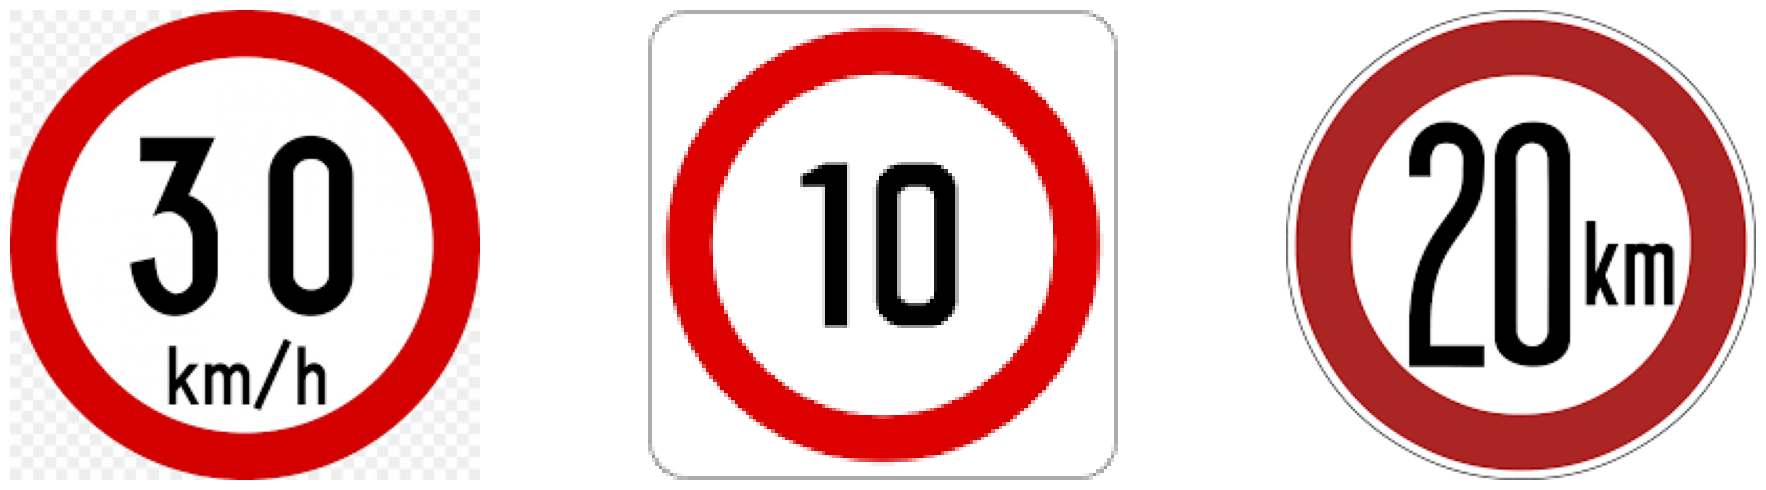

In [112]:
directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/train_inputs'  

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith('.jpg') or file.endswith('.png')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))  

for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(directory_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  

plt.tight_layout()
plt.show()


In [116]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 30. 

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 30 and is predicted with a confidence of 1.00


0

In [117]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 10. 

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 10 and is predicted with a confidence of 1.00


0

In [118]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 20. 

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 20 and is predicted with a confidence of 0.86


0

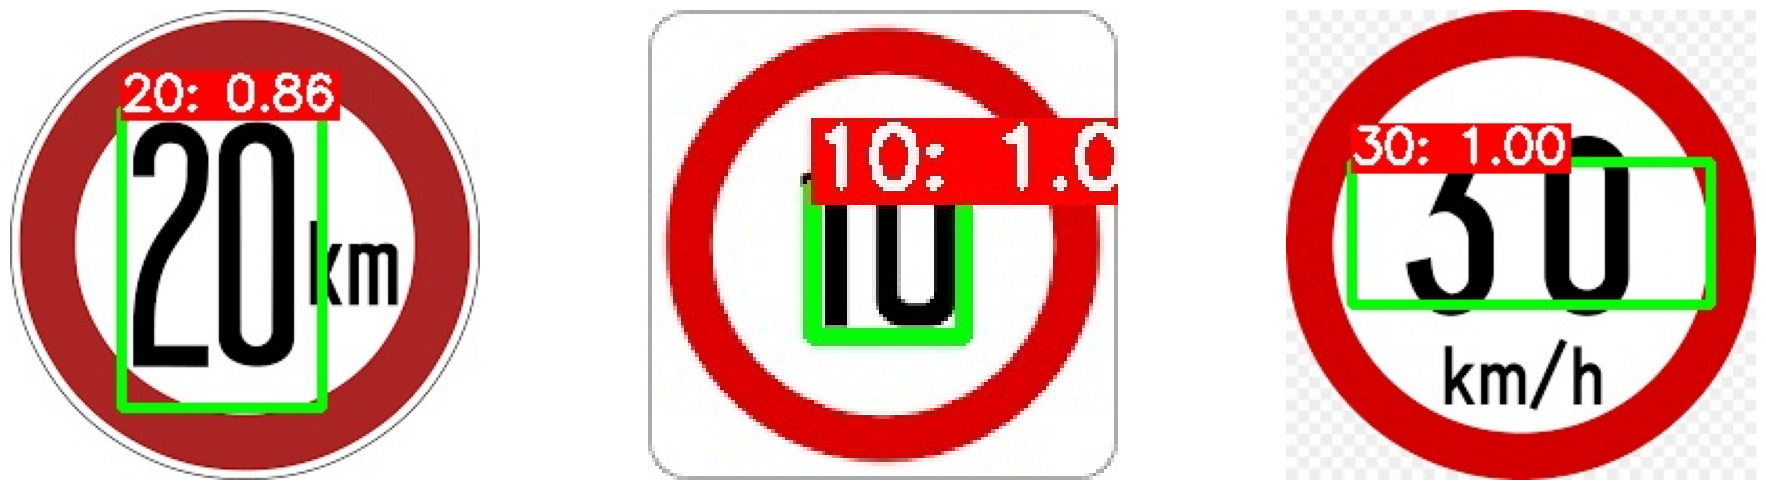

In [120]:
directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/train_outputs'  # Replace with your directory path

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith('.jpg') or file.endswith('.png')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # Adjust figure size as needed

for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(directory_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  

plt.tight_layout()
plt.show()

### Thus, the neural network works well with different classes and is working well while classifying images with a good confidence value in the training dataset

### Running our code on Testing Data

The follwoing cell represents the inputs we are testing

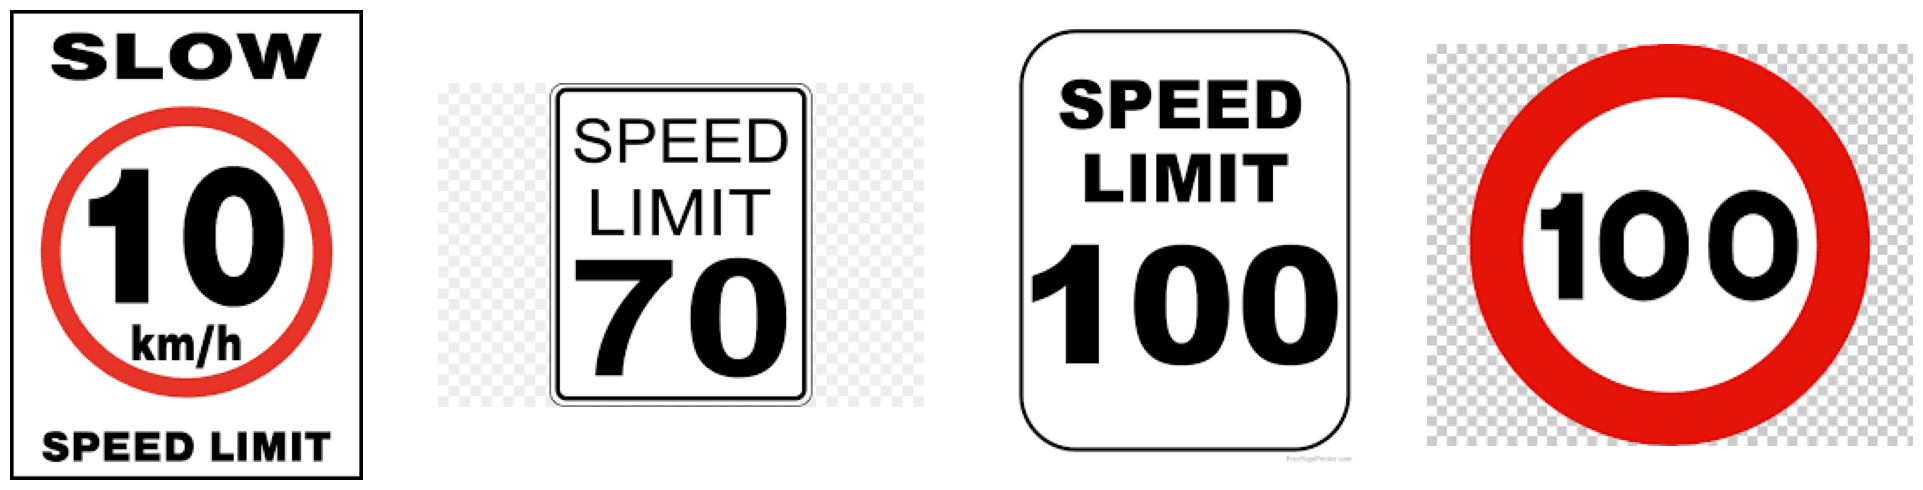

In [136]:
directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/test_inputs'  

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith('.jpeg') or file.endswith('.png')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  

for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(directory_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  

plt.tight_layout()
plt.show()


In [137]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 10. 

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 10 and is predicted with a confidence of 1.00


0

In [138]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 70. 

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 70 and is predicted with a confidence of 0.96


0

In [139]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 100. 

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 100 and is predicted with a confidence of 1.00


0

In [140]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 100.

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 100 and is predicted with a confidence of 0.92


0

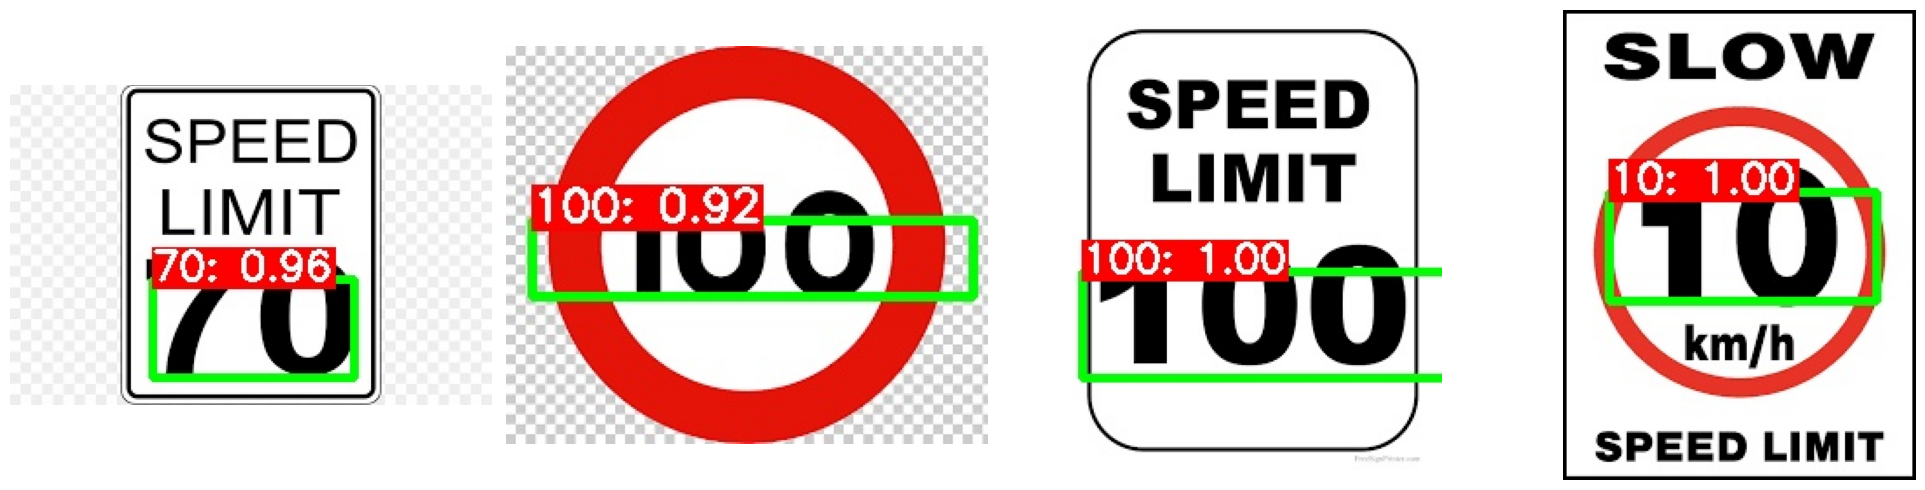

In [141]:
### YOUR CODE HERE
directory_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/test_outputs'  

all_files = os.listdir(directory_path)

image_files = [file for file in all_files if file.endswith('.jpg') or file.endswith('.png')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  

for ax, image_file in zip(axes, image_files):
    img_path = os.path.join(directory_path, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  

plt.tight_layout()
plt.show()


### Real Time Speed Detector

In the cell below please find attached a video of our neural network working on processing real time data received from a web camera. The image to the right is a testing image which when pointed at by our web camera produces an output of speed detected as 40 in the bounding box created around it. 



In [143]:
from IPython.display import Video

Video("/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/163F2EB9-B87E-4693-AB69-41471787776F.mov")

Link to the video in case the notebook doesn't play the video when downloaded.

[Google Drive- Real Time Execution](https://drive.google.com/file/d/1k9XJd31xHwJZE47zJOSX-Mk4LOT2LNeR/view?usp=sharing)

### Preparing for Model Training

[x] Data Annotation <br>
[x] YOLO Project Structure Setup <br>
[x] Neural Network Configuration Setup <br>

### Post Model Training Completion

[x] Python Code to test the network over unseen data 1. Static Data (Images) 2. Real Time Data (Videos and/or Live Camera Feed) <br>
[ ] How could we improve the testing accuracy? <br>

### Is our model perfect? Does it work well on every test input?

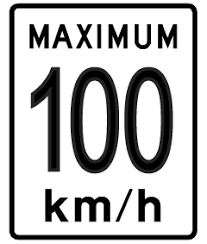

In [149]:
from IPython.display import Image, display

image_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/test_inputs/100_1.png'
display(Image(filename=image_path))

In [150]:
# Running our code on the first image to test if the network identifies the class correctly.

# Expected Output: Speed Limit is 100.

os.system('python3 darknet/csc542/object_detection_yolo.py')

Neural Network detected Speed is : 60 and is predicted with a confidence of 0.95


0

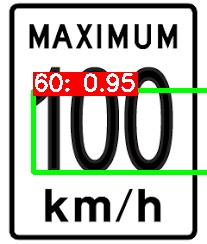

In [152]:
from IPython.display import Image, display

image_path = '/Users/ani/Desktop/NCSU Study/ncsu-csc-542/Proj74/darknet/csc542/test_outputs/100_1_yolo_out_py.jpg'
display(Image(filename=image_path))

### How can we improve the testing accuracy and thereby our model?

• What we've achieved in terms of data pre-processing suits our needs of building a working prototype of a speed limit detector but if this has to have real-world cases the data that this needs to be trained on needs to be severely pre-processed. 

- Some steps that we can think of are- Using not only transformations but also modification functions and filters to create better variability in the dataset while maintaining a good trade-off in between the bias and trade-off for the model.

• Hyper-parameter Tuning

- We believe that tuning the model in an optimized way while ensuring a correct loss algorithm could be of great use. We noticed while training that some classes were being overfit while we were training for classes that had a higher concentration of data to train on. Thus, data balance while maintaining and regularly keeping a check of our parameters could be of great use.

### Preparing for Model Training

[x] Data Annotation <br>
[x] YOLO Project Structure Setup <br>
[x] Neural Network Configuration Setup <br>

### Post Model Training Completion

[x] Python Code to test the network over unseen data 1. Static Data (Images) 2. Real Time Data (Videos and/or Live Camera Feed) <br>
[x] How could we improve the testing accuracy? <br>

### CSC/ECE 542 - Neural Networks

Project Authors:
1. Aniruddha Kulkarni, akulka24@ncsu.edu
2. Swara Shah, sshah42@ncsu.edu
3. Sai Ritvik Ramadhenu, sramadh@ncsu.edu

Thank you.